## Relative humidity in BL flight paths

*Fig. 6 caption:*  
Histogram for the mean relative humidity between 500 and 600 m for all radioson-
des from August to December 2020. The dashed yellow line marks the 87% value which is used
as threshold to differentiate between radiosonde profiles which belong to the higher or the lower
mode.  

*Fig. 7 caption:*   
Drift trajectory for the radiosondes launched between August and December 2020
up to 1 km height. The blue set indicates drifts where the radiosondes have a mean relative hu-
midity above 87% between 500 and 600 m, while the orange set includes drifts where the mean
relative humidity is lower than 87%. (Topography source: Polar Institute Norway)

In [3]:
import xarray as xr
import numpy as np
import seaborn as sns
import pandas as pd

from scipy.interpolate import griddata

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import colors

# TODO: Are these still needed?
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER

# TODO: Must reinstall this on functioning conda version
from osgeo import gdal, osr

%matplotlib notebook

### 1. DATA

In [4]:
# Radiosonde data for 08.2020 to 12.2020
path = "data/radiosondes/"
file = "nyalesund_RS_202008-12.nc"

RS_ds = xr.open_dataset(path+file)
RS_ds.rh.values = RS_ds.rh.values*100  # so that it is in percent 
# only low levels
RS_ds_sub = RS_ds.where((RS_ds.alt<1000) & (RS_ds.wdir<361),drop=True)


In [5]:
# Radiosonde to dataframe
RS_pd = RS_ds.where((RS_ds.alt<1000) & (RS_ds.wdir<361),drop=True).to_dataframe()

In [6]:
# ICON LEM data for 08.2020 to 12.2020 and only select the first timestep 
path = "data/model/12UTC_icon_lem_meteograms/"
file = "nyalesund_icon_lem_12UTC_meteogram_202008-12.nc"
icon_lem_ds = xr.open_dataset(path+file)
icon_lem_ds = icon_lem_ds.where((icon_lem_ds.time.dt.minute == 0 ) & 
                                (icon_lem_ds.time.dt.second == 0), drop=True)

### 2 Separating two modes in RH from Radiosondes

If one looks at the distribution from the histogram we may assume that the profiles can be differented using a limit for the mean between 500 and 600 m. For this we can first compute the mean for each profile for these levels. The distintion will be at **rh = 87%**.

In [7]:
rs_rh_sub = RS_ds_sub.where((RS_ds_sub.alt > 500) & (RS_ds_sub.alt < 600), drop = True).rh

mean_rh_500to600m = np.empty((len(icon_lem_ds.time), 2))
for t in range(len(icon_lem_ds.time)): 
    tmp_rs = rs_rh_sub.where((rs_rh_sub.time.dt.day == icon_lem_ds.time.dt.day[t]) 
                         & (rs_rh_sub.time.dt.month == icon_lem_ds.time.dt.month[t]),
                         drop=True )
    mean_rh_500to600m[t,0] = np.nanmean(tmp_rs.values)
    mean_rh_500to600m[t,1] = icon_lem_ds.time.values[t]

<ipython-input-7-f9bc2ddd56df>:8: RuntimeWarning: Mean of empty slice
  mean_rh_500to600m[t,0] = np.nanmean(tmp_rs.values)


[ 40.  43.  46.  49.  52.  55.  58.  61.  64.  67.  70.  73.  76.  79.
  82.  85.  88.  91.  94.  97. 100.]


<IPython.core.display.Javascript object>


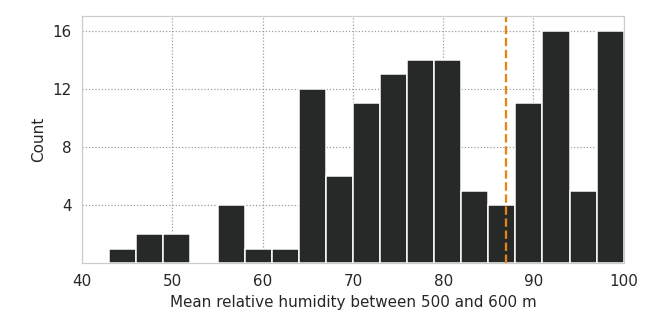

In [9]:
sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

rh_bins = np.linspace(40,100,21)
print(rh_bins)

fig  = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
plt.hist(mean_rh_500to600m[:,0], bins= rh_bins, color="#272828")
plt.xlabel("Mean relative humidity between 500 and 600 m")
plt.ylabel("Count")
plt.ylim(0,17)
plt.xlim(40,100)

# I will use 87 as barrier here
#np.nanmean(mean_rh_500to600m)
rh_lim = 87
plt.plot([rh_lim, rh_lim], [0,17], color="#e58516", linestyle="dashed")

plt.tight_layout()
ax.set_yticks([4,8,12,16])

plt.savefig('fig_6_distribution_mean_rh.png', dpi=300, format="png")

### 2.2 Create two sets
Create the two sets of the different distributions by sorting them based on the mean rh between 500 and 600m. The altitude can vary per day so one has to count the number of observations each day separately.

In [10]:
pd.to_datetime(mean_rh_500to600m[mean_rh_500to600m[:,0]>rh_lim,1])
c_high_mode=0; c_low_mode=0

# First get number of measurements for each category (alt can vary per day):
for t in range(len(mean_rh_500to600m[:,1])): 
    tmp_rs = RS_ds_sub.where((RS_ds_sub.time.dt.day == pd.to_datetime(mean_rh_500to600m[:,1]).day[t]) 
                         & (RS_ds_sub.time.dt.month == pd.to_datetime(mean_rh_500to600m[:,1]).month[t]),
                         drop=True )
    if mean_rh_500to600m[t,0] > rh_lim: 
        c_high_mode += len(tmp_rs.alt)
    else: 
        c_low_mode  += len(tmp_rs.alt)

# Now create an array with alt, pres, temp, rh, wdir and wspeed, lon, lat, id for the single sets
high_mode_arr = np.empty((c_high_mode, 9))
low_mode_arr = np.empty((c_low_mode, 9))

i_high = 0
i_low = 0
c = 0 # id to mark same day 
for t in range(len(mean_rh_500to600m[:,1])): 
    tmp_rs = RS_ds_sub.where((RS_ds_sub.time.dt.day == pd.to_datetime(mean_rh_500to600m[:,1]).day[t]) 
                         & (RS_ds_sub.time.dt.month == pd.to_datetime(mean_rh_500to600m[:,1]).month[t]),
                         drop=True )
    
    if mean_rh_500to600m[t,0] > rh_lim: 
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 0] = tmp_rs.alt
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 1] = tmp_rs.press
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 2] = tmp_rs.temp
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 3] = tmp_rs.rh
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 4] = tmp_rs.wdir
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 5] = tmp_rs.wspeed
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 6] = tmp_rs.lon
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 7] = tmp_rs.lat
        high_mode_arr[i_high:i_high+len(tmp_rs.press), 8] = c 

        i_high = i_high+len(tmp_rs.press)
    else: 
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 0] = tmp_rs.alt
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 1] = tmp_rs.press
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 2] = tmp_rs.temp
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 3] = tmp_rs.rh
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 4] = tmp_rs.wdir
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 5] = tmp_rs.wspeed
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 6] = tmp_rs.lon
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 7] = tmp_rs.lat
        low_mode_arr[i_low:i_low+len(tmp_rs.press), 8] = c
        
        i_low = i_low+len(tmp_rs.press)

    c += 1
        

In [11]:
print("count: ", c_high_mode, c_low_mode)

9752 16937


## 3. Plotting on map


### 3.3 Using geonorge terrain
I remapped the geonorge to lon lat because the other projection was giving me a headache. I used following stackoverflow answer for the coordinate transformation: https://gis.stackexchange.com/questions/73589/change-projection-system-tif-file
It uses the WGS84 projection now.   
Downloaded from: https://kartkatalog.geonorge.no/metadata/svalbard-dtm-20/9d118d31-182c-495b-b7be-d819cc7444b1

In [34]:
# Get data
gdal.UseExceptions()

#fname = '/work/tkiszler/data/geodata_svalbard/S0_DTM20.tif'
#fname = '/work/tkiszler/data/geodata_svalbard/Basisdata_2100_Svalbard_25833_SvalbardDTM50_TIFF/S0_DTM50.tif'
fname = '/work/tkiszler/data/geodata_svalbard/S0_DTM20_WGS84.tif'

ds = gdal.Open(fname)
data = ds.ReadAsArray()

In [35]:
# Create meshgrid for pcolormesh 
width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
min_lat = gt[0]
min_lon = gt[3] + width*gt[4] + height*gt[5] 
max_lat = gt[0] + width*gt[1] + height*gt[2]
max_lon = gt[3] 

lat_range = np.linspace(min_lat,max_lat,ds.RasterXSize)
lon_range = np.linspace(min_lon,max_lon,ds.RasterYSize)[::-1]

In [36]:
LAT, LON = np.meshgrid(lon_range[4650:4850], lat_range[5400:6400])

<IPython.core.display.Javascript object>


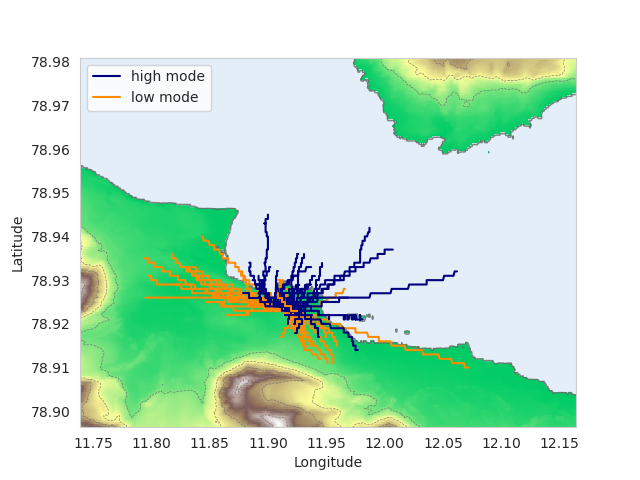

In [39]:
plt.figure()

# Create norm for colorbar
norm = FixPointNormalize(sealevel=0,vmax=np.nanmax(data[4650:4850,5400:6400]),vmin=0.03 )  #np.nanmin(data))

# data[lat,lon]
cbar = plt.pcolormesh(LON, LAT, data[4650:4850,5400:6400].T, alpha=0.8,
                      cmap=cut_terrain_map,norm=norm, shading="auto")
#plt.colorbar(cbar)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.contour(LON,LAT, data[4650:4850,5400:6400].T, colors='dimgrey', alpha=0.8, 
            linewidths=1, levels=[0.5])
plt.contour(LON,LAT, data[4650:4850,5400:6400].T, colors='dimgrey', alpha=0.8, 
            linewidths=0.5, linestyles="dashed", levels=[100,200,300,400,500,600,700])


for i in range(len(high_mode_arr[:,6])+len(low_mode_arr[:,6])):
    plt.plot(low_mode_arr[low_mode_arr[:,8]==i,6],
             low_mode_arr[low_mode_arr[:,8]==i,7], 
             color = "darkorange",linewidth=1.5, alpha=1)
for i in range(len(high_mode_arr[:,6])+len(low_mode_arr[:,6])):
    plt.plot(high_mode_arr[high_mode_arr[:,8]==i,6],
             high_mode_arr[high_mode_arr[:,8]==i,7], 
             color = "navy", alpha=1, linewidth=1.5)

plt.plot(high_mode_arr[high_mode_arr[:,8]==0,6],
        high_mode_arr[high_mode_arr[:,8]==0,7], 
        color = "navy", alpha=1,linewidth=1.5, label= "high mode")
plt.plot(low_mode_arr[low_mode_arr[:,8]==0,6],
        low_mode_arr[low_mode_arr[:,8]==0,7], 
        color = "darkorange", alpha=1, linewidth=1.5, label= "low mode")

plt.legend(loc='upper left')
#plt.savefig('/work/tkiszler/sciebo/UzK/nyalesund/analysis/plots/radiosonde/relative_humidity/radiosonde_drifts_depending_on_rh_mode_v2.png',
#           format="png", dpi=300)